<a href="https://colab.research.google.com/github/dannyweiland/Car-Crash-Analysis/blob/main/CarCrashAnalysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# CPSC-392-04 Final Project
Daniel Weiland

## Analysis Code

In [ ]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
from plotnine import *

from sklearn.preprocessing import StandardScaler #Z-Score Variables
from sklearn.linear_model import LinearRegression #Linear Regression
from sklearn.metrics import mean_squared_error, r2_score, accuracy_score, silhouette_score #model evaluation 

from sklearn.model_selection import KFold # k-fold cv
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict # cross validation metrics
from sklearn.model_selection import  train_test_split
from sklearn.decomposition import PCA


from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture

%matplotlib inline

In [ ]:
#Import Data
data = pd.read_csv("https://raw.githubusercontent.com/fivethirtyeight/data/master/bad-drivers/bad-drivers.csv")


data.head()

#Abbreviate Columns
data.columns = ['State', 'DriversInFatalCollisionPerBillionMiles', 'PercentSpeeding', 'PercentAlcohol', 'PercentNotDistracted', 'PercentInFatalNotInPrevious', 'InsPremium', 'InsLossesPerDriver'] 

In [ ]:
#Linear Regression Model
#Predicting Insurance Premiums with Losses Incurred by Insurance Companies for Collisions Per Driver
predictors = ['InsLossesPerDriver']

X = data[predictors]
y = data['InsPremium']

lr = LinearRegression()

kf = KFold(5)

mse = []
r2 = []
y_pred = []
trueV = []


for train,test in kf.split(X):
    X_train = X.iloc[train]
    X_test  = X.iloc[test]
    y_train = y[train]
    y_test  = y[test]
    

    z = StandardScaler()
    Xz_train = z.fit_transform(X_train)
    Xz_test = z.transform(X_test)
    
    # model
    model = lr.fit(Xz_train, y_train)
    
    # record accuracy
    y_pred = model.predict(Xz_test)
    trueV = y_test
    
    
    mse.append(mean_squared_error(y_test, y_pred))
    r2.append(r2_score(y_test,model.predict(Xz_test)))
  

print(np.mean(mse))
print(np.mean(r2))

20136.184300066892
0.17969709445372295


In [ ]:
RegDF = pd.DataFrame({"PredV" : y_pred,  
                      "TrueV": trueV,
                      "Xz_test": np.concatenate(Xz_test)})
Error = abs(RegDF["PredV"]-RegDF["TrueV"])

RegDF["Error"] = Error

RegDF

,PredV,TrueV,Xz_test,Error
41,724.544996,669.31,-1.593830,55.234996
42,995.661750,767.91,0.784916,227.751750
43,1001.481292,1004.75,0.835976,3.268708
44,782.786602,809.38,-1.082825,26.593398
45,783.387031,716.20,-1.077557,67.187031
46,987.117185,768.95,0.709947,218.167185
47,792.670586,890.03,-0.996104,97.359414
48,981.759511,992.61,0.662940,10.850489
49,769.577165,670.31,-1.198723,99.267165
50,840.797274,791.14,-0.573847,49.657274


In [ ]:
dataZ = data
dataZ = dataZ.drop(['State'], axis=1)

dataZ[['DriversInFatalCollisionPerBillionMiles', 'PercentSpeeding', 'PercentAlcohol', 'PercentNotDistracted', 'PercentInFatalNotInPrevious', 'InsPremium', 'InsLossesPerDriver']] = z.fit_transform(dataZ)

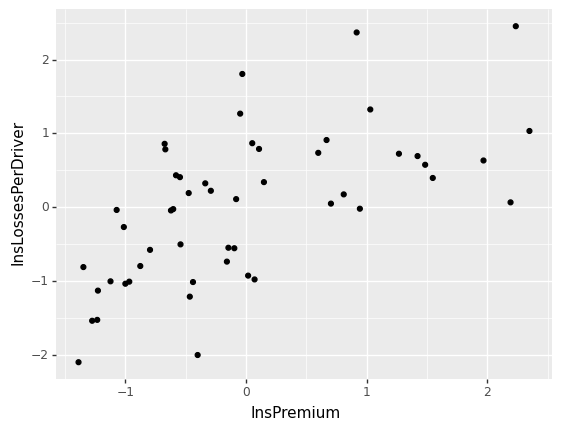

<ggplot: (8728778567765)>

In [ ]:
(ggplot(dataZ, aes(x='InsPremium', y='InsLossesPerDriver'))+geom_point())

#Algo Choice: GMM
#Why: Probabalistic, the clusters are overlapping, somewhat eliptical

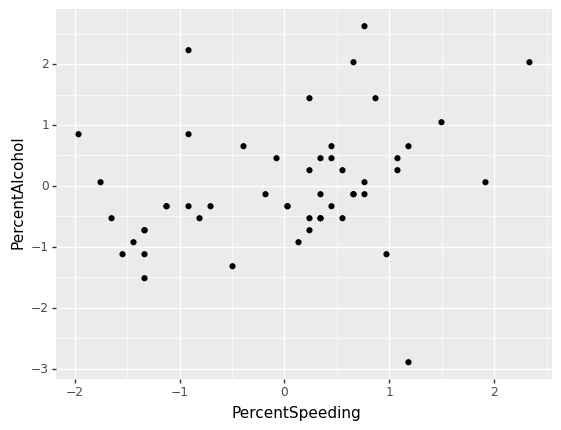

<ggplot: (8728778597765)>

In [ ]:
(ggplot(dataZ, aes(x='PercentSpeeding', y='PercentAlcohol'))+geom_point())

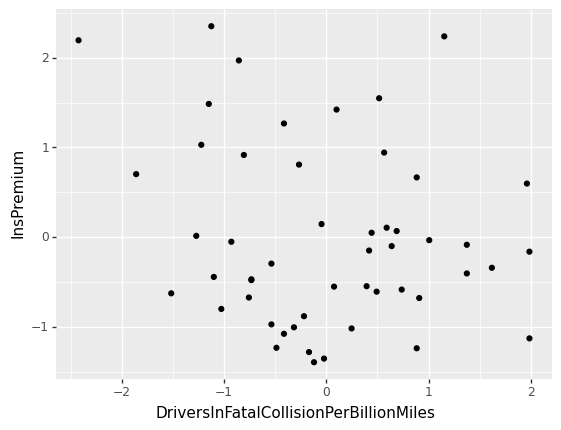

<ggplot: (8728779105113)>

In [ ]:
(ggplot(dataZ, aes(x='DriversInFatalCollisionPerBillionMiles', y='InsPremium'))+geom_point())

#Algo choice: GMM
#Why: GMM is probabilistic and excels when working with overlapping clusters

In [ ]:
#Implementing Clustering Algo

features = ['DriversInFatalCollisionPerBillionMiles', 'InsPremium', 'InsLossesPerDriver']
X = data[features]

z = StandardScaler()

X[features] = z.fit_transform(X)

EM = GaussianMixture(n_components = 2)

EM.fit(X)

cluster = EM.predict(X)

print("SILHOUETTE: ", silhouette_score(X, cluster))

data["cluster"] = cluster
X["cluster"] = cluster

SILHOUETTE:  0.3438678452784019


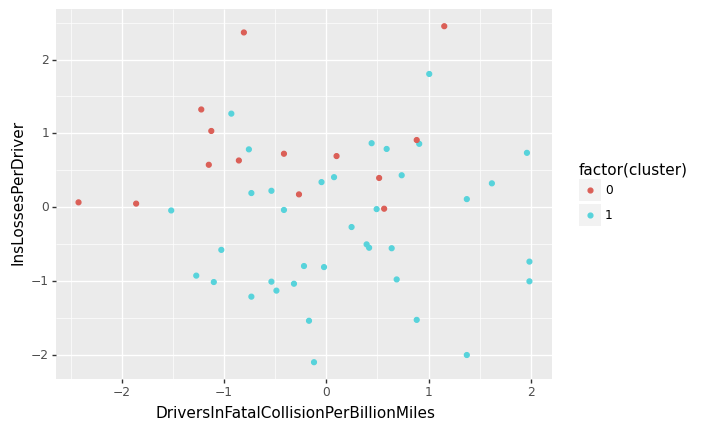

<ggplot: (8728778730189)>

In [ ]:
(ggplot(X, aes(x='DriversInFatalCollisionPerBillionMiles', y='InsLossesPerDriver', color="factor(cluster)"))+geom_point())

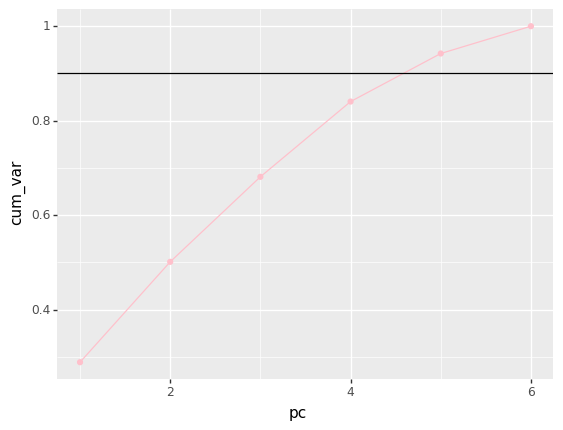

<ggplot: (8728778658921)>

In [ ]:
#Build PCA Model
predictors = ['PercentSpeeding', 'PercentAlcohol', 'PercentNotDistracted', 'PercentInFatalNotInPrevious', 'InsPremium', 'InsLossesPerDriver']


#Train Test Split
X_train, X_test, y_train, y_test = train_test_split(data[predictors], data["DriversInFatalCollisionPerBillionMiles"], test_size=0.1)
#X_train.head()

#Z-Score Predictor Variables
zscore = StandardScaler()
zscore.fit(X_train)
Xz_train = zscore.transform(X_train)
Xz_test = zscore.transform(X_test)

#Fit PCA Model to Training Data
pca = PCA()
pca.fit(Xz_train)



#Make Scree Plot
pcaDF = pd.DataFrame({"expl_var" : pca.explained_variance_ratio_,
                      "pc" : range(1,7),  
                      "cum_var": pca.explained_variance_ratio_.cumsum()})



#(ggplot(pcaDF, aes(x = "pc", y = "expl_var")) + geom_line() + geom_point())

(ggplot(pcaDF, aes(x = "pc", y = "cum_var")) + geom_line(color = "pink") +
 geom_point(color = "pink") + geom_hline(yintercept = 0.90))

In [ ]:
loadings = pd.DataFrame({"loading": pca.components_.flatten(),
            "comp": np.repeat(range(1,7), 6,
        axis=0), "variable":np.tile(predictors,6) })

loadings.head(35)


,loading,comp,variable
0,-0.138272,1,PercentSpeeding
1,-0.305709,1,PercentAlcohol
2,0.050071,1,PercentNotDistracted
3,0.218431,1,PercentInFatalNotInPrevious
4,0.651464,1,InsPremium
5,0.642494,1,InsLossesPerDriver
6,0.504541,2,PercentSpeeding
7,0.654801,2,PercentAlcohol
8,0.244443,2,PercentNotDistracted
9,-0.350716,2,PercentInFatalNotInPrevious


# Results

**Question 1: Can we accurately predict Car Insurance Premiums using the Losses incurred by insurance companies for collisions per insured driver variable?**

**Short answer:** `Losses Incurred by Insurance Companies for Collisions Per Insured Driver` is helpful towards predicting `Car Insurance Premium ($)`, but only explains a small part of the variance of this variable.

**Explanation:** To answer this question I created a linear regression model with the `Losses incurred by insurance companies for collisions per insured driver ($)` variable as my independent variable and `Car Insurance Premiums ($)` as my dependent variable.  In order to assess the predictive performance of my model I used K-Fold cross validation in order to split the data into multiple training and testing sets, before fitting each of these training sets to my model and testing their accuracy in predicting the testings sets.  I recorded Mean Squared Error and R-Squared values and recorded the averages of these values over the 5 different splits.  The resulting R-squared was ~.1797, which indicates that my independent variable  (`Losses Incurred by Insurance Companies for Collisions Per Insured Driver`) explains ~18% of the variance in my dependent variable.  While the relationship between these two variables seems to be significant, using the `Losses Incurred by Insurance Companies for Collisions Per Insured Driver` alone will not yield very accurate predictions.  





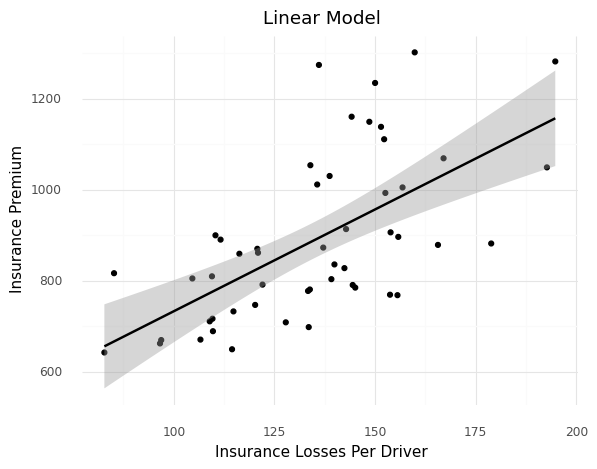

<ggplot: (8728783811777)>

In [ ]:
#Plot showing the distribution of the data with trendline
(ggplot(data, aes(x = 'InsLossesPerDriver', y = 'InsPremium'))+geom_point()+geom_smooth(method = "lm", se = 'FALSE')+theme_minimal()+
 labs(x="Insurance Losses Per Driver", y="Insurance Premium", title="Linear Model"))

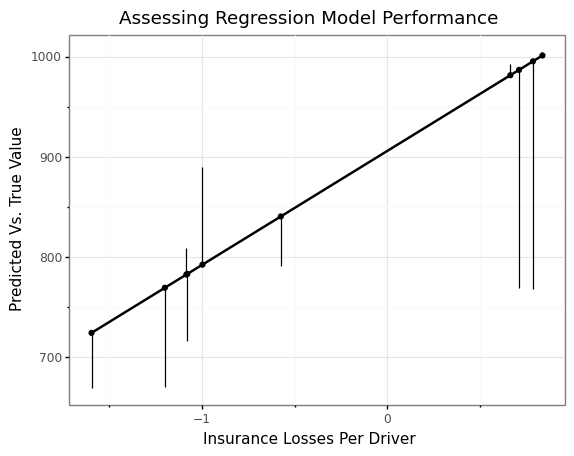

<ggplot: (8728778497569)>

In [ ]:
(ggplot(RegDF, aes(x="Xz_test", y="PredV"))+geom_segment(aes(xend = "Xz_test", yend="TrueV"))+geom_point()+geom_smooth(method="lm")+theme_bw()+
 labs(x="Insurance Losses Per Driver", y="Predicted Vs. True Value", title="Assessing Regression Model Performance"))

**Question #2: Are there any distinct clusters in the dataset**

**Short Answer:** Yes

**Explanation:** You can see in the visualizations below that there are some identifiable clusters, especially in the `InsLossesPerDriver and InsPremium` and `DriversInFatalCollisionPerBillionMiles and InsPremium` plots.  To assign these data points to their identifiable clusters, I assessed the characteristics of the multiple scatterplots, and selected a clustering algorithm that is best suited at classifying data with those characteristics.  The clusters in the scatter plots below showed some slight overlap between clusters, so I elected to use a Gaussian Mixture Model, which excels at dealing with this type of data. I then visualized the results of my clustering algorithm by re-plotting my variables and identifying the clusters by color. It appears that my model was able to successfully assign these clusters.   



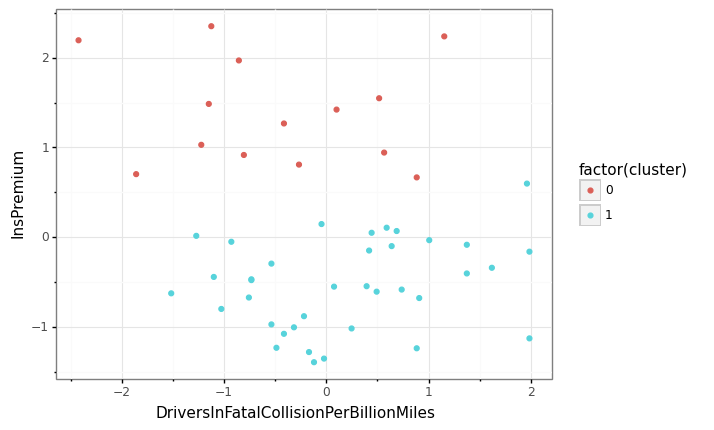

<ggplot: (8728779109109)>

In [ ]:
(ggplot(X, aes(x='DriversInFatalCollisionPerBillionMiles', y='InsPremium', color="factor(cluster)"))+geom_point()+theme_bw())

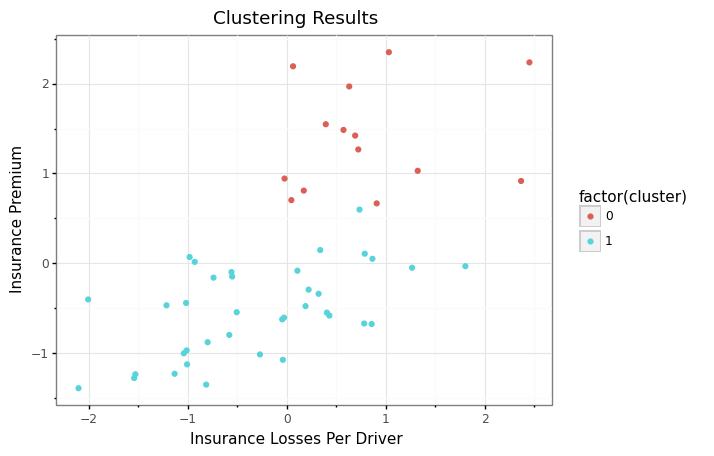

<ggplot: (8728783706433)>

In [ ]:
(ggplot(X, aes(x='InsLossesPerDriver', y='InsPremium', color = "factor(cluster)"))+geom_point()+theme_bw()+labs(x="Insurance Losses Per Driver", y="Insurance Premium", title="Clustering Results"))

**Question 3: Which Variables have the strongest impact on fatal collisions per billion miles**

**Short Answer:** Insurance Premium and Insurance Losses Per Driver are the most effective at explaining the variance in the Fatal Collisions Per Billion Miles Variable

**Explanation:** By fitting my dataset to a PCA model and analyzing the scree plot and loading scores, I was able to identify which variables explained the most variance of the Fatal Collisions Per Billion Miles variable.  From my PCA model I was able to find that the first two components of my model were able to explain roughly half of the variance of the Fatal Collisions Per Billion Miles variable.  I then analyzed the loading scores of each of the principal components, and identified that the Insurance Premium and Insurance Losses Per Driver were the most strongly correlated with this first principal component.

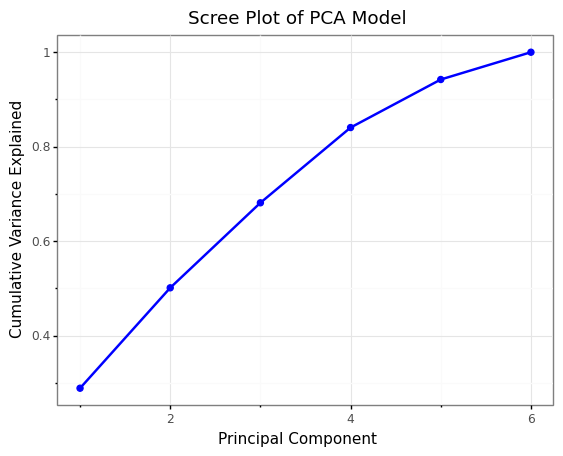

<ggplot: (8728777891117)>

In [ ]:
(ggplot(pcaDF, aes(x = "pc", y = "cum_var")) + geom_line(color = "blue", size=1) +
 geom_point(color = "blue", size = 2)+theme_bw()+labs(x="Principal Component", y="Cumulative Variance Explained", title="Scree Plot of PCA Model"))

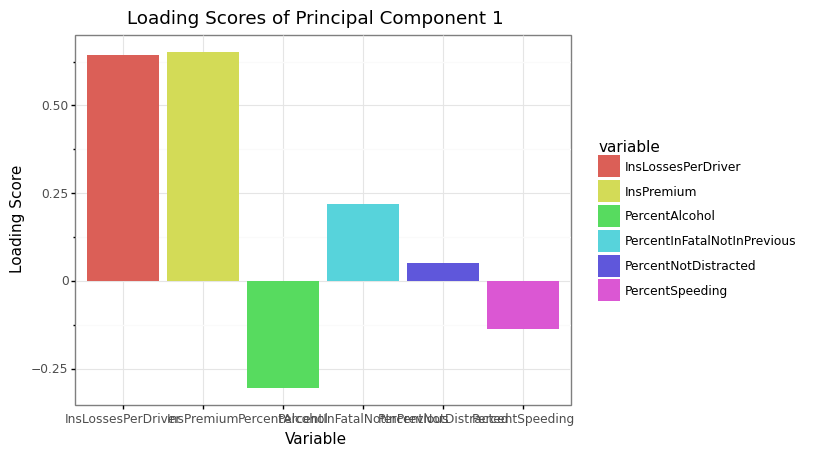

<ggplot: (8728777866957)>

In [ ]:
comp1Loadings =loadings[:6]
(ggplot(comp1Loadings, aes(x="variable", y="loading", fill = "variable"))+
 geom_col()+
 labs(x = "Variable", y = "Loading Score", title = "Loading Scores of Principal Component 1")+
 theme_bw())